##### Sertis Takehome project: https://www.kaggle.com/c/whale-categorization-playground

Kawisorn Kamtue

Start time: 10:30am 8/9/2018

In [1]:
import pandas as pd
import os
from os.path import join
import matplotlib.pyplot as plt
from keras.regularizers import l2
from PIL import Image
from tensorflow.python.keras import backend as K
import tensorflow as tf
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.python.ops import math_ops
from keras import optimizers,applications,metrics
from keras.layers import Dropout, Flatten,GlobalMaxPooling2D, Dense, GlobalAveragePooling2D,Conv2D,MaxPooling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint,EarlyStopping
#np.random.seed(1337)  # for reproducibility
import random
from keras.layers.core import *
from keras.optimizers import SGD, RMSprop
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from skimage.transform import warp, AffineTransform


Using TensorFlow backend.


Since previously using data augmentation and transfer learning still have not successfully solved the problem 
of little and sparse data, I changed my approach to one-shot learning. One-shot learning is a weakly supervised 
algorithm that is suitable for a small labelled training set. The idea of one shot learning is to learn a similarity 
function that given a pair of images, output the similarity between two images. In other word, we want to find a metric
embedding space where we can apply usual distance function like L1,L2, euclidean distance to

In [2]:
train_image_path = './train/train'
train_data = pd.read_csv('train.csv',delimiter = ',')
num_sample = train_data.shape[0]
label = {} # set label for whale_id
label_to_num = {} # match id(str) to num(int)
num_to_label = {} # match num(int) to id(str)
index = 0
for i in range(num_sample):
    label[train_data['Image'][i]] = train_data['Id'][i]
    if not train_data['Id'][i] == 'new_whale':
        if not train_data['Id'][i] in label_to_num:
            label_to_num[train_data['Id'][i]] = index
            num_to_label[index] = train_data['Id'][i]
            index += 1
        
nb_classes = index
print( "Number of images %d" %(num_sample))
print( "Number of whale id %d" %(nb_classes))
print( "Number of training samples/class \t Number of classes")

for num_sample, num_id in train_data["Id"].value_counts().value_counts().sort_index().iteritems():
    print( "%d\t\t\t\t\t%d" %(num_sample,num_id))

Number of images 9850
Number of whale id 4250
Number of training samples/class 	 Number of classes
1					2220
2					1034
3					492
4					192
5					102
6					61
7					40
8					23
9					21
10					9
11					7
12					7
13					9
14					5
15					4
16					5
17					4
18					2
19					2
20					1
21					3
22					3
23					1
26					1
27					1
34					1
810					1


In [3]:
image_size = 224

In [4]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def augment_data(image):
    scale_factor = 1 + np.random.rand()/4
    rotate_angle = 3.14*(np.random.rand()-1/2)/2
    shear_angle = 3.14*(np.random.rand()-1/2)/4
    trans_x = random.randrange(1,5)
    trans_y = random.randrange(1,5)
    tform = AffineTransform(scale=(scale_factor, scale_factor), rotation=rotate_angle, shear=shear_angle,
                        translation=(trans_x, trans_y))
    aug_image = warp(image, tform.inverse, output_shape=(image_size, image_size))
    return aug_image
    

First we will prepare a training set. As mentioned earlier, our input will be a pair of training images and the output will be the similarities. For each class (whale id), we will createa N positive pairs and N negative pairs. Positive pair is a pair of whale flukes with same id and negative pair is a pair of whale flukes with different ids. There will not be a class "new_whale". As we can see that there are 2220 classes with only one training sample, we will use data augmentation so that each class contains at least two training samples.

In [5]:
nb_aug_data = 1
X_train = []
Y_train = []
image_file_train = os.listdir(train_image_path)
for images in image_file_train:
    im = Image.open((join(train_image_path,images))).convert('RGB')
    im = im.resize((image_size, image_size))
    im = np.array(im).astype('float32')
    final_im = preprocess_input(im)
    if not label[images]=='new_whale':
        X_train.append(np.array(final_im))
        Y_train.append(label_to_num[label[images]])
        for i in range(nb_aug_data):
            aug_image = augment_data(final_im)
            X_train.append(np.array(aug_image))
            Y_train.append(label_to_num[label[images]])
            
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [6]:
print(X_train.shape)

(18080, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Augmented Image')

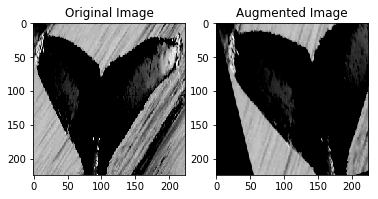

In [7]:
import matplotlib.pyplot as plt

k=20
fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(X_train[k])
a.set_title('Original Image')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(X_train[k+1])
imgplot.set_clim(0.0, 0.7)
a.set_title('Augmented Image')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')


#plt.figure(1)
#plt.subplot(211)
#plt.imshow(X_train[k])

#plt.subplot(212)
#plt.imshow(X_train[k+1])
#plt.show()

We will train a model to  do one-shot classification, that is to give it two images and train it to guess whether they have the same category. The main idea of Siamese neural network is to train CNNs so that maps image to an embedding space where usual distance (euclidean distance)
signifies the similarities between images. Two images will pass through the same CNN (same weight, same architecture) and their outputs will be compared using euclidean distance. The final output of the model will be the distance(similarity between the image)

In [8]:
def euclidean_distance(vects):
    '''
    Usual euclidean distance
    '''
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''
    Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def create_pairs(x, whale_ids):
    """ 
    This function creates input for siamese nn.
    For each class, create N pairs of postives pairs and negative pairs. Positive pairs will
    be labeled 1 while negative pairs will be labeled 0
    
    """
    pairs = []
    labels = []
    n = min([len(whale_ids[d]) for d in range(nb_classes)]) - 1
    for d in range(nb_classes):
        for i in range(n):
            class_list = list(whale_ids[d])
            z1, z2 = random.sample(class_list,2) # positive pair
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, nb_classes)
            dn = (d + inc) % nb_classes # other whale ids
            z1, z2 = whale_ids[d][i], whale_ids[dn][i] # negative pair
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(in_dim):
    """ Base network to that maps images to embedding space
    """
    
    inp = Input(shape=in_dim) # 384x384x1
    x   = Conv2D(64, (9,9), strides=2, activation='relu')(inp)

    x   = MaxPooling2D((2, 2), strides=(2, 2))(x) # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), activation='relu')(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1,1), activation='relu')(x) # 48x48x128
    
    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1,1), activation='relu')(x) # 24x24x256

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1,1), activation='relu')(x) # 12x12x384

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1,1), activation='relu')(x) # 6x6x512
    
    x = GlobalMaxPooling2D()(x) # 512
    model = Model(inputs = inp,outputs = x)
    return model


def compute_accuracy(y_true, y_pred):
    '''
    Compute classification accuracy with a fixed threshold on distances.
    Note that here the distance 0 means two images are identical while the positive pair is labeled 1.
    Therefore we apply y_pred <0.5 to reverse the score
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''
    Compute classification accuracy with a fixed threshold on distances.
    Note that here the distance 0 means two images are identical while the positive pair is labeled 1.
    Therefore we apply y_pred <0.5 to reverse the score
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))



In [9]:

input_shape = (image_size,image_size,3)

# create training+test positive and negative pairs
whale_ids = [np.where(Y_train == i)[0] for i in range(nb_classes)]
train_pairs, train_y = create_pairs(X_train, whale_ids)


In [10]:
print(train_pairs.shape)

(8500, 2, 224, 224, 3)


In [11]:
# Parameters
nb_epochs = 10

# Create branch network
base_network = create_base_network(input_shape)

# Input: a pair of images of identical dimension
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# The feature vectors of each image
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Euclidean distance between two images
distance = Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([processed_a, processed_b])

# Siamese Neural Network
model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([train_pairs[:, 0,:,:,:], train_pairs[:, 1,:,:,:]], train_y,batch_size=128,epochs=nb_epochs)

# compute final accuracy on training and test sets
y_pred = model.predict([train_pairs[:, 0], train_pairs[:, 1]])
tr_acc = compute_accuracy(train_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))


Epoch 1/10
8500/8500 [==============================] - 441s 52ms/step - loss: 11.2392 - accuracy: 0.5041
Epoch 2/10
8500/8500 [==============================] - 439s 52ms/step - loss: 0.6154 - accuracy: 0.5726
Epoch 3/10
8500/8500 [==============================] - 437s 51ms/step - loss: 0.4629 - accuracy: 0.6389
Epoch 4/10
8500/8500 [==============================] - 438s 52ms/step - loss: 0.4471 - accuracy: 0.6476
Epoch 5/10
8500/8500 [==============================] - 450s 53ms/step - loss: 0.3312 - accuracy: 0.6447
Epoch 6/10
8500/8500 [==============================] - 457s 54ms/step - loss: 0.3093 - accuracy: 0.6566
Epoch 7/10
8500/8500 [==============================] - 444s 52ms/step - loss: 0.3062 - accuracy: 0.6555
Epoch 8/10
8500/8500 [==============================] - 440s 52ms/step - loss: 0.2839 - accuracy: 0.6784
Epoch 9/10
8500/8500 [==============================] - 449s 53ms/step - loss: 0.2427 - accuracy: 0.7278
Epoch 10/10
8500/8500 [==============================]

To get the label for the new image x, we can compare x with all training images and output the labels of the images x
is the most similar.

In [ ]:
"""
y_predict_5 = []
for images in image_file_test:
    im = Image.open((join(test_image_path,images))).convert('RGB')
    im = im.resize((image_size, image_size))
    im = np.array(im).astype('float32')
    final_im = preprocess_input(im)
    final_im = final_im.reshape([1,224,224,3])
    top_5_label = []
    top_5_score = []
    for i in range(X_train.shape):
        train_im = X_train[i].reshape([1,224,224,3])
        score = model.predict([train_im,final_im])
        if len(top_5_score)<5:
            top_5_score.append(score)
            top_5_label.append(num_to_label[Y_train[i]])
        elif min(top_5_score) < score:
            min_ind = np.argmin(top_5_score)
            top_5_score[min_ind] = score
            top_5_label[min_ind] = num_to_label[Y_train[i]]
    new_whale_thres = 0.5
    if min(top_5_score) > new_whale_thres:
            min_ind = np.argmin(top_5_score)
            top_5_score[min_ind] = score
            top_5_label[min_ind] = 'new_whale'
    y_predict_5.append(top_5_label)
"""

However this step takes too long ( O(MN) where M and N are sizes of training images and test images). Luckily the distance we use in this Siamese NN is euclidean distance. We can use python implementation of k-nearest neighbor with optimization algorithm like Ball-tree (using ball tree data structure). First we have to transform training images and test images onto embedding spaces. We can simply use base_network.predict to get the feature map of the images.

In [14]:
test_image_path = './test/test'
image_file_test = os.listdir(test_image_path)
X_test = []
image_file_test = os.listdir(test_image_path)
for images in image_file_test:
    im = Image.open((join(test_image_path,images))).convert('RGB')
    im = im.resize((image_size, image_size))
    im = np.array(im).astype('float32')
    final_im = preprocess_input(im)
    X_test.append(np.array(final_im))
X_test = np.array(X_test)

In [15]:
X_features =  base_network.predict(X_train) # getting feature maps

In [16]:
print(X_features.shape)

(18080, 512)


In [17]:
from sklearn.neighbors import KNeighborsClassifier
X_test_features = base_network.predict(X_test)
neigh = KNeighborsClassifier(n_neighbors=5,algorithm='ball_tree',metric='euclidean')
neigh.fit(X_features,Y_train)
distances,indices=neigh.kneighbors(X_test_features)

In [18]:
file = open('submission3.csv',"w")

i = 0
threshold = 0.1
file.write('Image,Id')
file.write('\n')
for images in image_file_test:
    file.write(images+',')
    ind_ = indices[i]
    nw = False
    p=0
    j=0
    while(p<5):
        if (not nw) and distances[i][j] > threshold:
            file.write('new_whale')
            file.write(' ')
            p+=1
            nw = True
        else:
            file.write(num_to_label[Y_train[ind_[j]]])
            file.write(' ')
            p+=1
            j+=1
    file.write('\n')
    i+=1
file.close()

test score = 0.40297